In [1]:
import sys
import xarray as xr
import numpy as np
import pandas as pd
import math
import glob
import yaml
import cartopy
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colorbar import Colorbar # different way to handle colorbar
import matplotlib.ticker as mticker
import cmocean.cm as cmo
import seaborn as sns

# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.feature as cfeature
import dask

# import personal modules
# Path to modules
sys.path.append('../modules')
# Import my modules
from utils import roundPartial, select_months_ds
from plotter import draw_basemap, plot_terrain, plot_arscale_cbar
from colorline import colorline
from trajectory_post_funcs import calculate_heatmaps_from_trajectories
import customcmaps as ccmaps

dask.config.set(**{'array.slicing.split_large_chunks': True})

In [2]:
server='expanse'
if server == 'comet':
    path_to_data = '/data/projects/Comet/cwp140/'
elif server == 'expanse':
    path_to_data = '/expanse/nfs/cw3e/cwp140/'
elif server == 'skyriver':
    path_to_data = '/home/dnash/comet_data/'
path_to_out  = '../out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../figs/'      # figures

In [3]:
HUC8_ID = '14050001'
HUC8_lbl = 'Upper Yampa'
fname = path_to_data + 'preprocessed/ERA5_trajectories/combined/PRISM_HUC8_{0}.nc'.format(HUC8_ID)
ds = xr.open_dataset(fname)
ds['ar_scale'] = ds.ar_scale.fillna(0) 

ds

<xarray.Dataset>
Dimensions:             (index: 72, start_date: 2056)
Coordinates:
  * index               (index) int64 0 1 2 3 4 5 6 7 ... 65 66 67 68 69 70 71
    time                (start_date, index) datetime64[ns] ...
  * start_date          (start_date) datetime64[ns] 2000-01-05 ... 2023-12-24
    lon                 (start_date, index) float64 ...
    lat                 (start_date, index) float64 ...
Data variables: (12/18)
    level               (start_date, index) float64 ...
    q                   (start_date, index) float64 ...
    u                   (start_date, index) float64 ...
    v                   (start_date, index) float64 ...
    w                   (start_date, index) float64 ...
    IVT                 (start_date, index) float64 ...
    ...                  ...
    coastal_IVT         (start_date) float64 ...
    ar_scale_strict     (start_date) float64 ...
    ar_strict           (start_date) float64 ...
    tARget_strict       (start_date) float64 ...
    coastal_IVT_strict  (start_date) float64 ...
    time_match          (start_date) <U13 ...

In [4]:
fname = path_to_data + 'preprocessed/PRISM/PRISM_HUC8_CO_sp.nc'
PRISM = xr.open_dataset(fname)
PRISM = PRISM.sel(HUC8=HUC8_ID)

water_year = (PRISM.date.dt.month >= 10) + PRISM.date.dt.year
PRISM.coords['water_year'] = water_year

PRISM

<xarray.Dataset>
Dimensions:     (date: 8766)
Coordinates:
  * date        (date) datetime64[ns] 2000-01-01 2000-01-02 ... 2023-12-31
    HUC8        <U8 '14050001'
    water_year  (date) int64 2000 2000 2000 2000 2000 ... 2024 2024 2024 2024
Data variables:
    prec        (date) float64 ...
    extreme     (date) int64 ...
    lat         float64 ...
    lon         float64 ...
    sp          (date) float32 ...
    sp_start    (date) float64 ...

In [5]:
## use AR Scale as criteria for identifying AR at coast
varname = 'ar_scale'
thres = 0

## use Rutz AR dt for identifying AR at coast
varname = 'ar'
thres = 0

## use tARgetv4 AR dt for identifying AR at coast
varname = 'tARget'
thres = 0


In [6]:
## get dates where AR is yes
ar_days = ds.where(ds[varname] > thres, drop=True).start_date.values
# ar_days = ds.where(ds.coastal_IVT > 250, drop=True).start_date.values

## select those dates from the PRISM dataset
tmp = PRISM.sel(date=ar_days)

ar_prec = tmp.prec.groupby(tmp.water_year).sum(dim="date") / 25.4 # convert from mm to inches
ar_prec

<xarray.DataArray 'prec' (water_year: 25)>
array([3.7327374 , 3.11666339, 1.93373976, 4.15420827, 5.0965563 ,
       7.05231772, 6.08904528, 2.02018701, 7.16461693, 5.44216575,
       3.76514094, 8.73642402, 2.14787598, 1.48478543, 5.04475945,
       3.89907874, 3.72148386, 4.36320354, 5.28095984, 6.65559331,
       4.52296929, 2.37485315, 4.2695189 , 4.72001378, 1.52275748])
Coordinates:
    HUC8        <U8 '14050001'
  * water_year  (water_year) int64 2000 2001 2002 2003 ... 2021 2022 2023 2024

In [7]:
annual_prec = PRISM.prec.groupby(PRISM.water_year).sum(dim="date") / 25.4 # convert from mm to inches
annual_prec

<xarray.DataArray 'prec' (water_year: 25)>
array([21.93670593, 22.34248619, 19.31667458, 28.61315922, 26.45194535,
       27.96526659, 30.87993705, 26.30074337, 29.77425024, 28.55038242,
       27.12850893, 38.95721243, 18.9102031 , 26.64272471, 33.02012655,
       25.85749656, 26.27611974, 25.99575074, 21.05465623, 29.75688747,
       23.47192575, 19.89320281, 26.5895059 , 29.50212891,  6.20920956])
Coordinates:
    HUC8        <U8 '14050001'
  * water_year  (water_year) int64 2000 2001 2002 2003 ... 2021 2022 2023 2024

In [8]:
(ar_prec / annual_prec)*100

<xarray.DataArray 'prec' (water_year: 25)>
array([17.01594312, 13.94949228, 10.01072806, 14.51852358, 19.26722679,
       25.21813155, 19.71845106,  7.68110231, 24.0631313 , 19.0616212 ,
       13.87890855, 22.42569083, 11.35829146,  5.5729489 , 15.27783197,
       15.07910378, 14.16298866, 16.7842952 , 25.08214707, 22.36656409,
       19.26969836, 11.93801306, 16.05715771, 15.99889213, 24.52417601])
Coordinates:
    HUC8        <U8 '14050001'
  * water_year  (water_year) int64 2000 2001 2002 2003 ... 2021 2022 2023 2024

In [9]:
df = pd.DataFrame({'Total Precipitation': annual_prec.values,
                   'AR Associated': ar_prec.values,
                   'Percent': (ar_prec.values/annual_prec.values)*100},
                  index=annual_prec.water_year.values)

df

,Total Precipitation,AR Associated,Percent
2000,21.936706,3.732737,17.015943
2001,22.342486,3.116663,13.949492
2002,19.316675,1.933740,10.010728
2003,28.613159,4.154208,14.518524
2004,26.451945,5.096556,19.267227
2005,27.965267,7.052318,25.218132
2006,30.879937,6.089045,19.718451
2007,26.300743,2.020187,7.681102
2008,29.774250,7.164617,24.063131
2009,28.550382,5.442166,19.061621


/scratch/dnash/job_32086155/ipykernel_703339/1944903103.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  d1.set_xticklabels(d1.get_xticklabels(), rotation=45)


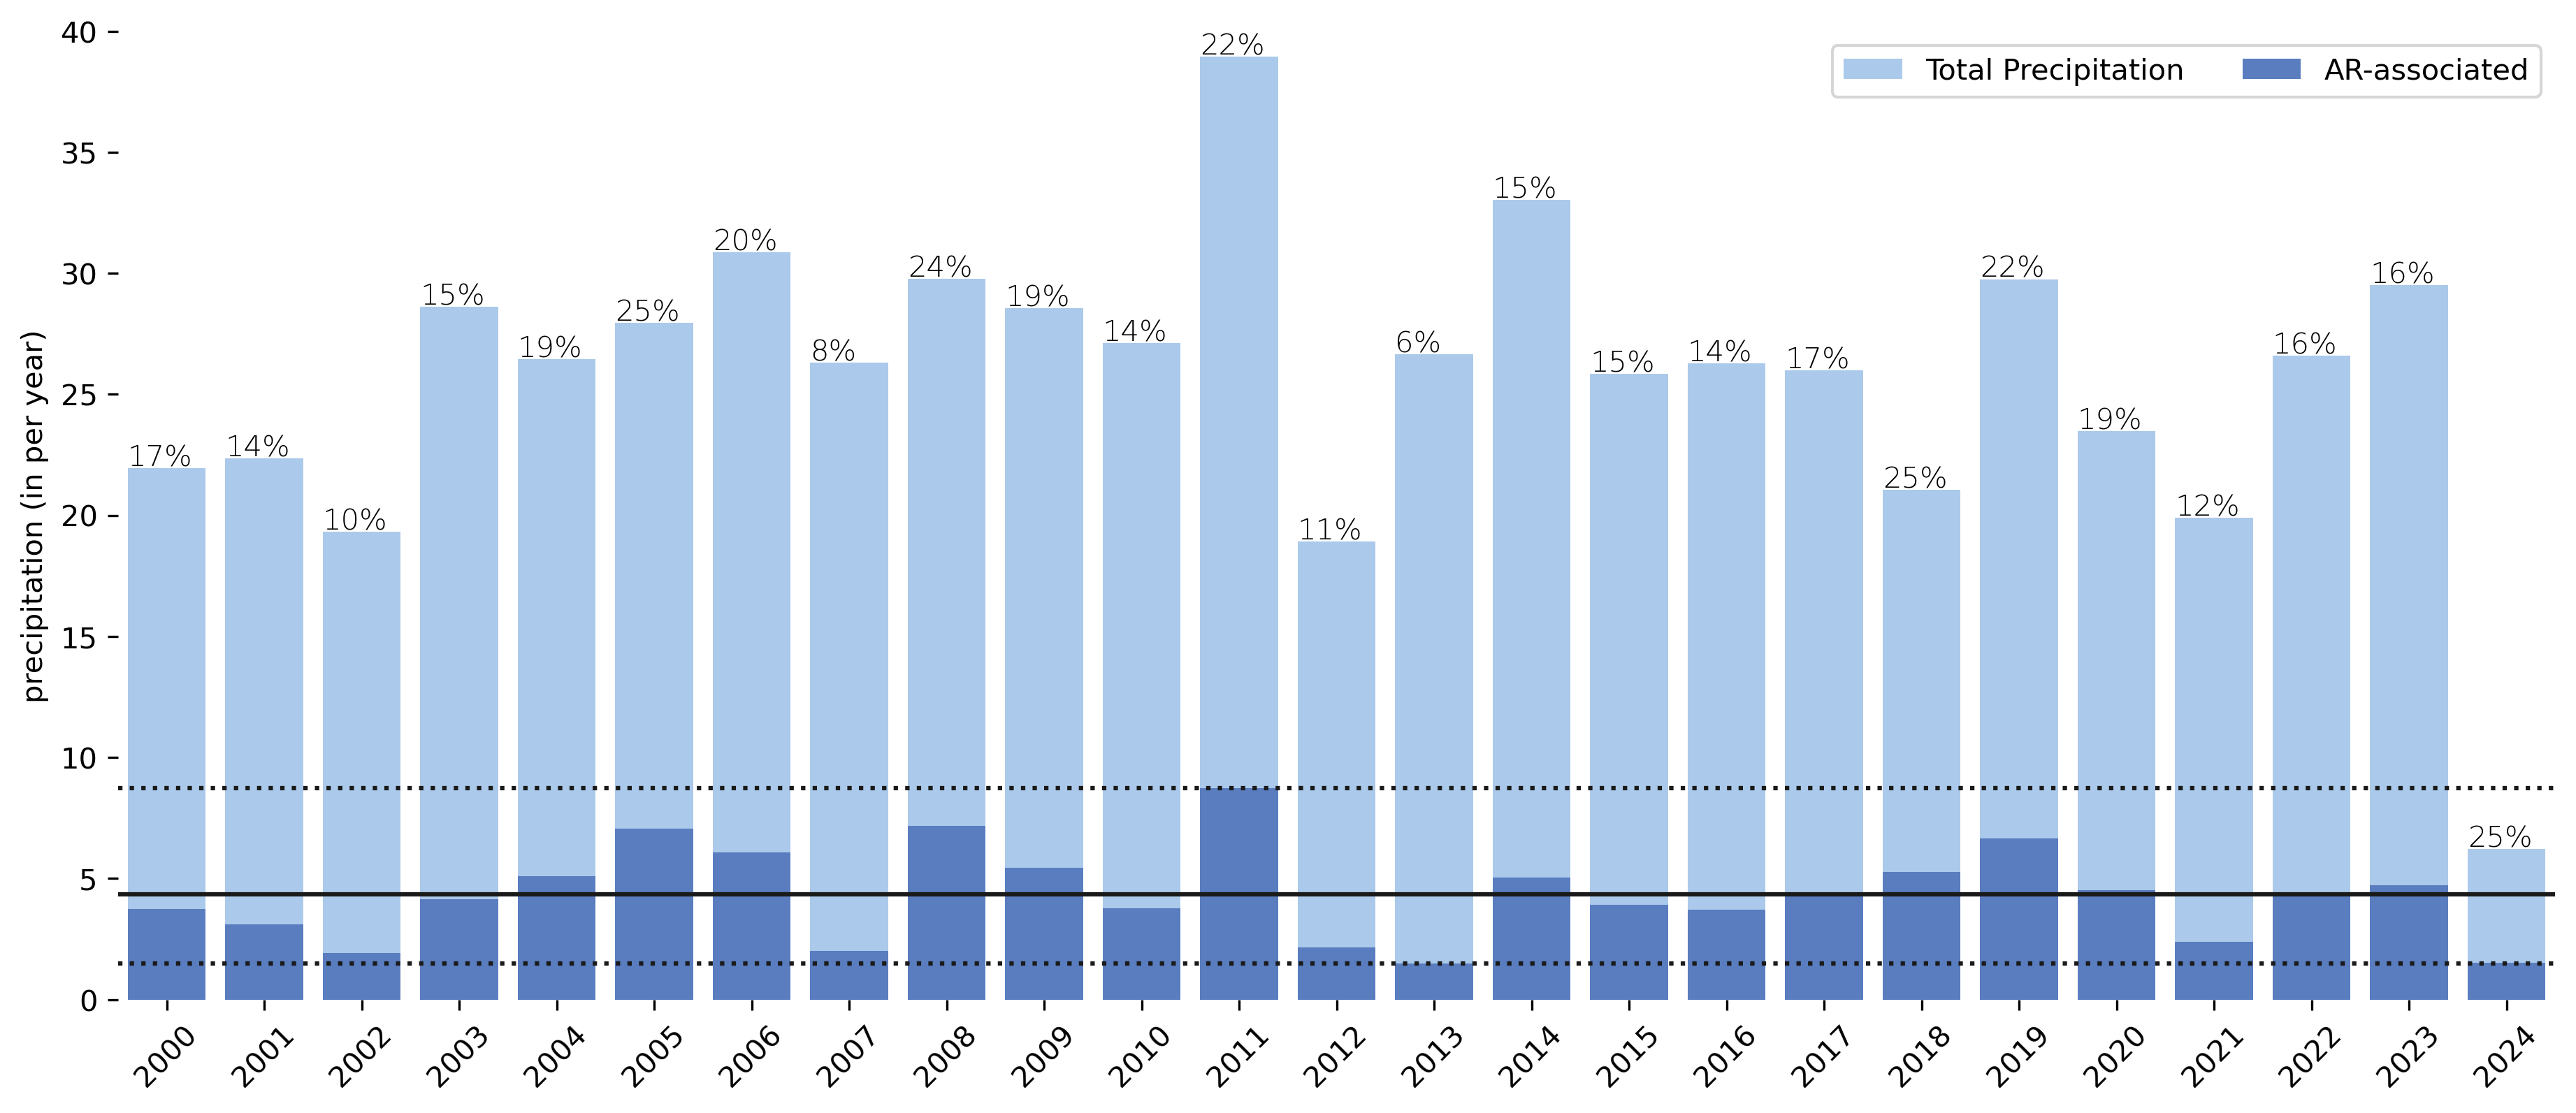

In [10]:
fig = plt.figure(figsize=(15,6))
fig.dpi = 300
fname = '../figs/time_series_Upper_Yampa'
fmt1 = 'png'
gs = fig.add_gridspec(nrows=1, ncols=1)
color_list = ['b', 'r', 'g']


## Initialize the matplotlib figure
ax = fig.add_subplot(gs[0, 0])

# Plot the total precip
sns.set_color_codes("pastel")
d1 = sns.barplot(x=df.index, y="Total Precipitation", data=df, color='b', label="Total Precipitation")

# Plot the precipitation where ARs were involved
sns.set_color_codes("muted")
d2 = sns.barplot(x=df.index, y="AR Associated", data=df, color='b', label="AR-associated")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="upper right", frameon=True)
ax.set(ylim=(0, 40), ylabel="precipitation (in per year)", xlabel="")
sns.despine(left=True, bottom=True)
#     ax.set_title(subtitles[i])
d1.set_xticklabels(d1.get_xticklabels(), rotation=45)

## add min/max/mean/median lines
ax.axhline(y=df['AR Associated'].min(), color='k', linestyle=':')
ax.axhline(y=df['AR Associated'].max(), color='k', linestyle=':') 
ax.axhline(y=df['AR Associated'].mean(), color='k', linestyle='-')

yloc = df['Total Precipitation'].values
xloc = np.arange(0, len(df), 1)
proportion = df['Percent'].values
for i, (x, prop) in enumerate(zip(xloc, proportion)):
    if prop > 0:
        plt.text(x=x-0.4,
                 y=yloc[i]+0.1,
                 s=f'{int(np.round(prop, 0))}%',
                 color="black",
                 fontsize=10,
                 fontweight="light", zorder=200)
    
fig.savefig('%s.%s' %(fname, fmt1), bbox_inches='tight', dpi=fig.dpi)
plt.show()

In [11]:
extreme_days = PRISM.where(PRISM.extreme > 0, drop=True).date.values
extreme_days
ext_prec = PRISM.sel(date = extreme_days)

extreme_prec = ext_prec.prec.groupby(ext_prec.water_year).sum(dim="date") / 25.4 # convert from mm to inches
extreme_prec

<xarray.DataArray 'prec' (water_year: 25)>
array([ 4.52919685,  0.58362598,  1.63010236,  5.81688583,  3.38854331,
        5.57896457,  5.36688976,  4.50351181,  3.34683071,  4.34809055,
        4.97597244, 12.2684685 ,  2.93899213,  3.65662992,  7.21619685,
        4.56137008,  3.92575591,  4.89534252,  4.08101969,  8.08665354,
        5.14426378,  2.28255906,  5.42245669,  5.65192126,  1.94891339])
Coordinates:
    HUC8        <U8 '14050001'
  * water_year  (water_year) int64 2000 2001 2002 2003 ... 2021 2022 2023 2024

In [12]:
extreme_AR = ds.sel(start_date = extreme_days)
extreme_AR = extreme_AR.where(extreme_AR[varname] > thres, drop=True).start_date.values
extreme_AR

## select those dates from the PRISM dataset
tmp = PRISM.sel(date=extreme_AR)

extreme_ar_prec = tmp.prec.groupby(tmp.water_year).sum(dim="date") / 25.4 # convert from mm to inches
extreme_ar_prec
## need to fix bc there were years with no ar prec
# extreme_ar_prec = [1.05002362, 0.0, 0.60440945, 0.0, 1.88874409, 1.88114567, 1.03925591,
#        0.87485827, 1.28244094, 0.91176772, 1.30415354, 2.53234252,
#        0.92724803, 0.47244488, 2.21646063, 1.00309055, 0.99031102,
#        2.3395315 , 2.06331102, 1.8730748 , 1.75300394, 0.0, 1.98682283,
#        1.14646063, 0.81968504]

extreme_ar_prec = [1.00852362, 0., 0.60440945, 0.99308661, 1.75545276, 1.88114567,
       1.32994488, 0.87485827, 1.8168189 , 1.04922047, 1.30415354,
       2.53234252, 0, 0, 1.14062205, 0.95775984, 0.99031102, 1.54695669,
       2.06331102, 1.8730748 , 1.75300394, 0.47188189, 1.98682283,
       0.57187795, 0.81968504]

In [13]:
(extreme_ar_prec / extreme_prec)*100

<xarray.DataArray 'prec' (water_year: 25)>
array([22.26716244,  0.        , 37.0780059 , 17.07247898, 51.80552824,
       33.71854486, 24.78055147, 19.42613469, 54.28475648, 24.13060302,
       26.20901855, 20.64106469,  0.        ,  0.        , 15.8064154 ,
       20.99719653, 25.2259958 , 31.60058124, 50.55871275, 23.16254542,
       34.07686727, 20.67337048, 36.64063989, 10.11829294, 42.05856689])
Coordinates:
    HUC8        <U8 '14050001'
  * water_year  (water_year) int64 2000 2001 2002 2003 ... 2021 2022 2023 2024

In [14]:
df = pd.DataFrame({'Total Precipitation': extreme_prec.values,
                   'AR Associated': extreme_ar_prec,
                   'Percent': (extreme_ar_prec/extreme_prec.values)*100},
                  index=extreme_prec.water_year.values)

df

,Total Precipitation,AR Associated,Percent
2000,4.529197,1.008524,22.267162
2001,0.583626,0.000000,0.000000
2002,1.630102,0.604409,37.078006
2003,5.816886,0.993087,17.072479
2004,3.388543,1.755453,51.805528
2005,5.578965,1.881146,33.718545
2006,5.366890,1.329945,24.780551
2007,4.503512,0.874858,19.426135
2008,3.346831,1.816819,54.284756
2009,4.348091,1.049220,24.130603


/scratch/dnash/job_32086155/ipykernel_703339/2591584583.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  d1.set_xticklabels(d1.get_xticklabels(), rotation=45)


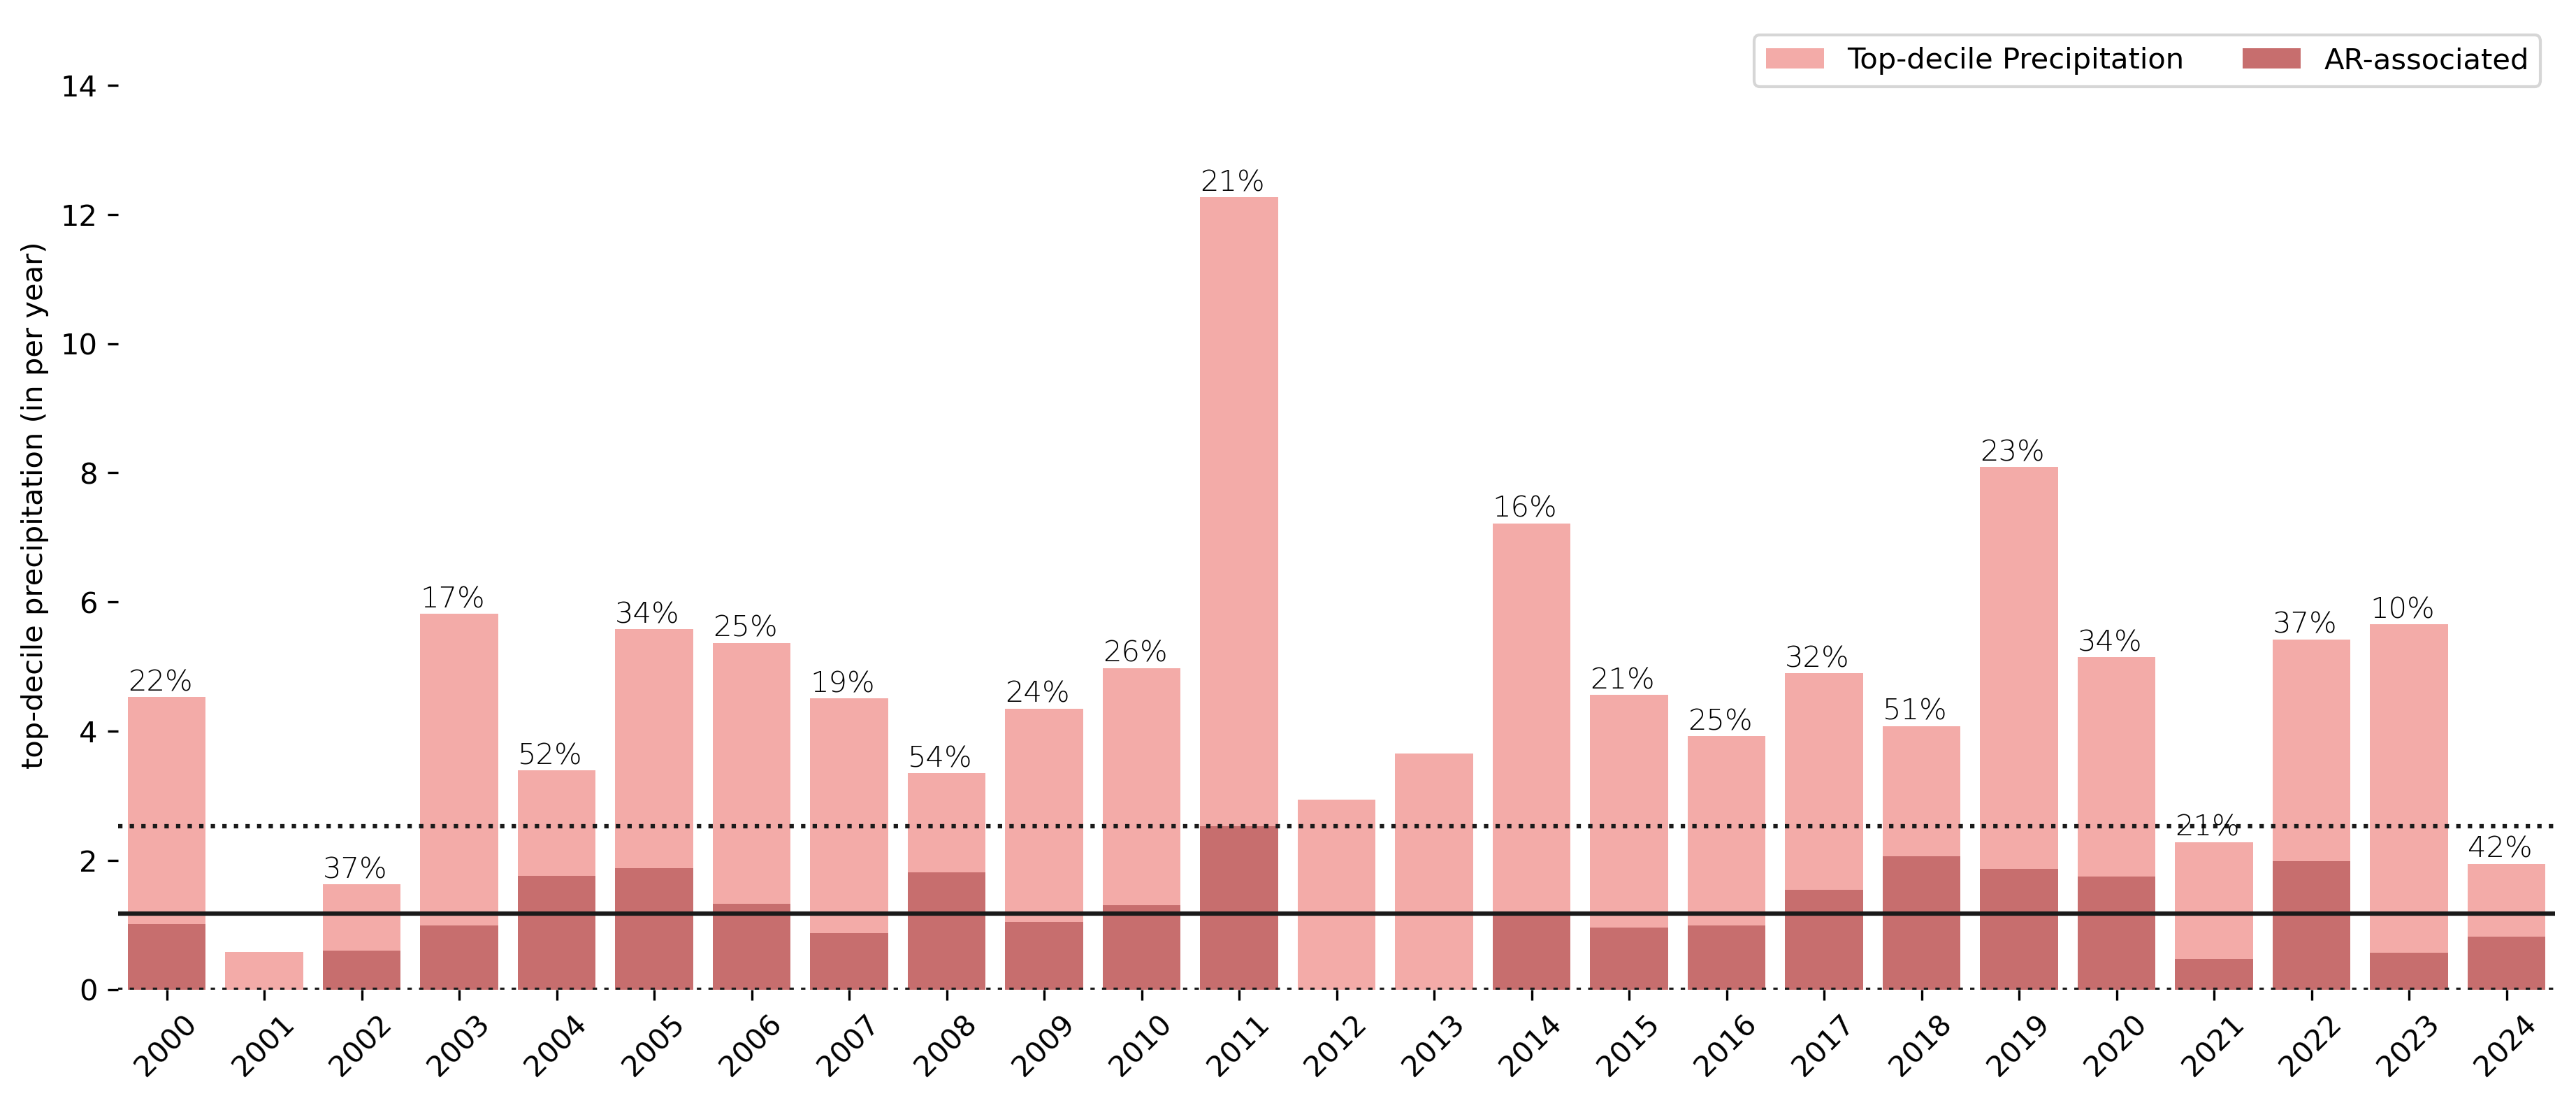

In [15]:
fig = plt.figure(figsize=(15,6))
fig.dpi = 300
fname = '../figs/time_series_extreme_Upper_Yampa'
fmt1 = 'png'
gs = fig.add_gridspec(nrows=1, ncols=1)
color_list = ['b', 'r', 'g']


## Initialize the matplotlib figure
ax = fig.add_subplot(gs[0, 0])

# Plot the total precip
sns.set_color_codes("pastel")
d1 = sns.barplot(x=df.index, y="Total Precipitation", data=df, color='r', label="Top-decile Precipitation")

# Plot the precipitation where ARs were involved
sns.set_color_codes("muted")
d2 = sns.barplot(x=df.index, y="AR Associated", data=df, color='r', label="AR-associated")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="upper right", frameon=True)
ax.set(ylim=(0, 15), ylabel="top-decile precipitation (in per year)", xlabel="")
sns.despine(left=True, bottom=True)
#     ax.set_title(subtitles[i])
d1.set_xticklabels(d1.get_xticklabels(), rotation=45)

## add min/max/mean/median lines
ax.axhline(y=df['AR Associated'].min(), color='k', linestyle=':')
ax.axhline(y=df['AR Associated'].max(), color='k', linestyle=':') 
ax.axhline(y=df['AR Associated'].mean(), color='k', linestyle='-')

yloc = df['Total Precipitation'].values
xloc = np.arange(0, len(df), 1)
proportion = df['Percent'].values
for i, (x, prop) in enumerate(zip(xloc, proportion)):
    if prop > 0:
        plt.text(x=x-0.4,
                 y=yloc[i]+0.1,
                 s=f'{int(np.round(prop, 0))}%',
                 color="black",
                 fontsize=10,
                 fontweight="light", zorder=200)
    
fig.savefig('%s.%s' %(fname, fmt1), bbox_inches='tight', dpi=fig.dpi)
plt.show()

In [18]:
AR = ds.where(ds[varname] > thres, drop=True).ar_scale
da_groupby_monthly = AR.groupby('start_date.month').count(['start_date'])
## calculate monthly count (interannual time series)
monthly_count = AR.resample(start_date='1MS').count(['start_date'])

In [19]:
monthly_count

<xarray.DataArray 'ar_scale' (start_date: 288)>
array([ 3.,  5.,  2., nan,  2.,  1., nan, nan, nan,  1., nan,  1.,  1.,
       nan, nan,  2.,  2., nan, nan, nan, nan,  3.,  1.,  2.,  1.,  2.,
       nan, nan, nan, nan, nan, nan,  1., nan,  4.,  2.,  2.,  2.,  3.,
       nan, nan, nan, nan, nan, nan, nan,  1.,  2.,  4., nan,  3.,  1.,
        1., nan, nan, nan,  3.,  4.,  3.,  3.,  6.,  3.,  4., nan, nan,
       nan, nan,  1., nan, nan,  5.,  4.,  6.,  6.,  4.,  3., nan, nan,
       nan, nan, nan,  1.,  2.,  2., nan,  2., nan, nan,  1.,  1., nan,
       nan,  1.,  4., nan,  8.,  5.,  5.,  1.,  2., nan, nan, nan, nan,
       nan,  2.,  3.,  5.,  5.,  2.,  1., nan,  2.,  2., nan, nan, nan,
       nan, nan, nan,  3.,  3., nan,  1.,  1., nan, nan, nan, nan,  1.,
       nan,  6.,  7.,  3.,  5.,  3.,  3., nan, nan, nan, nan,  1.,  1.,
        1.,  4.,  2.,  1.,  1.,  1., nan, nan, nan, nan, nan, nan,  2.,
        1.,  2.,  1.,  5.,  1., nan, nan, nan,  1., nan,  1., nan,  6.,
        4.,  5., nan,  1., nan, nan, nan, nan,  1.,  3., nan, nan,  2.,
        2., nan,  1., nan, nan, nan,  3., nan,  1.,  4.,  4.,  1.,  3.,
       nan, nan, nan, nan, nan,  1.,  1.,  1.,  3.,  7.,  5., nan,  1.,
        1., nan, nan, nan,  1.,  1.,  2., nan,  3.,  3., nan,  4., nan,
       nan, nan, nan, nan,  2.,  3.,  3.,  2.,  5.,  4.,  1.,  1., nan,
       nan, nan, nan,  5.,  1.,  3.,  6.,  4.,  2., nan,  1., nan, nan,
       nan, nan, nan,  1.,  2.,  1.,  2., nan, nan, nan, nan, nan, nan,
       nan,  3.,  1.,  5.,  4., nan,  1.,  1.,  1., nan, nan, nan, nan,
        1.,  1.,  5.,  4., nan,  5., nan, nan, nan, nan, nan, nan, nan,
        2.,  3.])
Coordinates:
  * start_date  (start_date) datetime64[ns] 2000-01-01 2000-02-01 ... 2023-12-01

In [20]:
df = pd.DataFrame({'AR Count': monthly_count.values},
                  index=monthly_count.start_date.values)

df

,AR Count
2000-01-01,3.0
2000-02-01,5.0
2000-03-01,2.0
2000-04-01,NaN
2000-05-01,2.0
...,...
2023-08-01,NaN
2023-09-01,NaN
2023-10-01,NaN
2023-11-01,2.0


In [21]:
## create datetime labels for the x-axis
date_lst = df.index.values
xtck_lbl = []
for i, x in enumerate(date_lst):
    t = pd.to_datetime(str(x))
    xtck_lbl.append(t.strftime('%Y-%m'))

xtcks = np.arange(0, len(date_lst), 1)

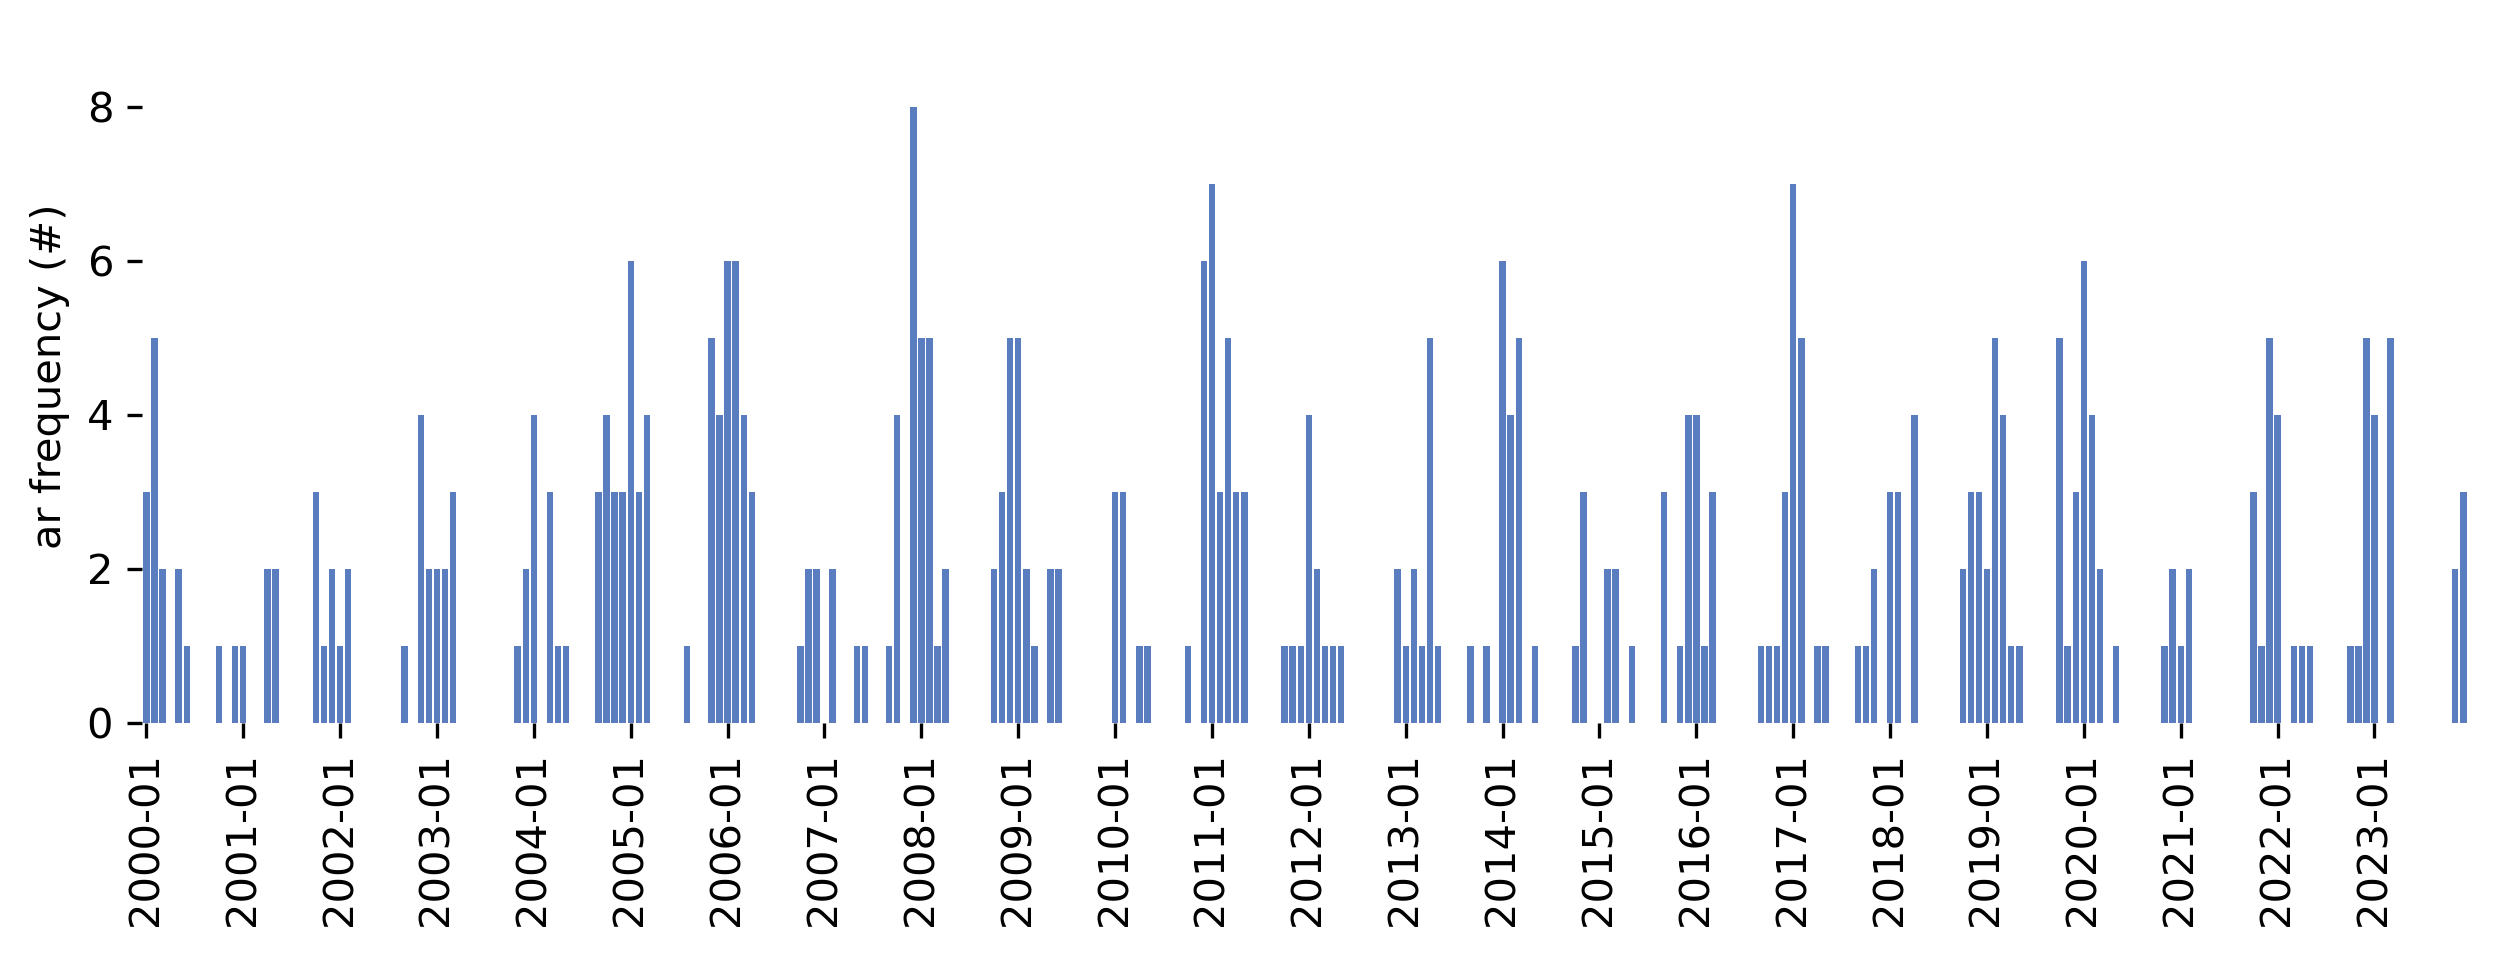

In [22]:
fig = plt.figure(figsize=(10,3))
fig.dpi = 300
fname = '../figs/monthly_count_time_series_Upper_Yampa'
fmt1 = 'png'
gs = fig.add_gridspec(nrows=1, ncols=1)
color_list = ['b', 'r', 'g']


## Initialize the matplotlib figure
ax = fig.add_subplot(gs[0, 0])

# Plot the precipitation where ARs were involved
sns.set_color_codes("muted")
d2 = sns.barplot(x=df.index, y="AR Count", data=df, color='b')

# Add a legend and informative axis label
ax.set(ylim=(0, 9), ylabel="ar frequency (#)", xlabel="")
sns.despine(left=True, bottom=True)
ax.set_xticks(xtcks[::12]) # set the labels every year
ax.set_xticklabels(xtck_lbl[::12], fontsize=10)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    
fig.savefig('%s.%s' %(fname, fmt1), bbox_inches='tight', dpi=fig.dpi)
plt.show()